# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [1]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [3]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [4]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [5]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a8f0b735cf0>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [6]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b1(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:02<00:00, 11.4MB/s]


In [7]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [8]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [9]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [10]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0873 | train_acc: 0.3516 | test_loss: 0.9161 | test_acc: 0.6629
Epoch: 2 | train_loss: 0.8259 | train_acc: 0.7930 | test_loss: 0.7940 | test_acc: 0.7235
Epoch: 3 | train_loss: 0.7285 | train_acc: 0.7852 | test_loss: 0.7172 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.6853 | train_acc: 0.7656 | test_loss: 0.6269 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.5909 | train_acc: 0.7891 | test_loss: 0.6281 | test_acc: 0.8362
[INFO] Total training time: 11.797 seconds


### Make predictions on the entire test dataset with the model

In [11]:
def test_pred(model:torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              class_names: list,
              device: torch.device = device):
  pred_probs = []
  targets = []

  model.eval()

  with torch.inference_mode():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)

      y_pred_labels = torch.argmax(torch.softmax(model(X), dim=1), dim=1)
      y_pred_probs = torch.softmax(model(X), dim=1)

      pred_probs.append(y_pred_probs.cpu())
      targets.append(y.cpu())

  return torch.cat(pred_probs, dim=0), torch.cat(targets, dim=0)
preds, targets = test_pred(model_0, test_dataloader, class_names)

### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.0 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [13]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


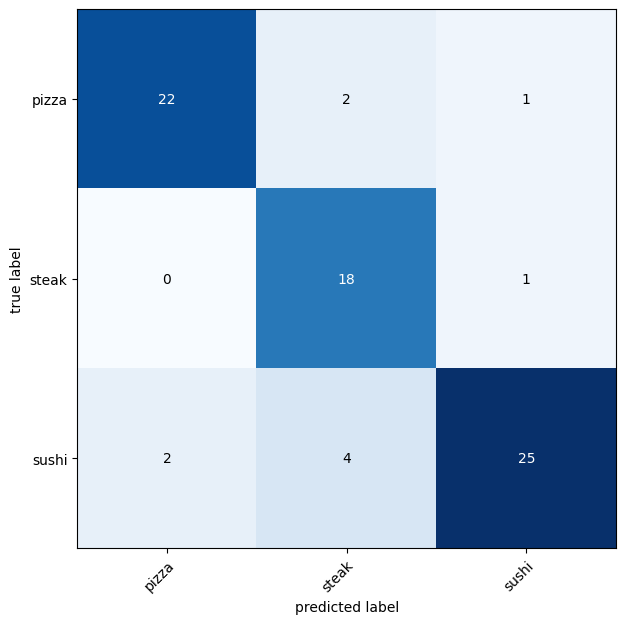

In [14]:
from mlxtend.plotting import plot_confusion_matrix

confmat = torchmetrics.ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=preds, target=targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [15]:
prediction_labels = torch.argmax(preds, dim=1)
prediction_probabilities = [pred.max().cpu() for pred in preds]
prediction_probabilities = torch.stack(prediction_probabilities)

In [16]:
prediction_labels, prediction_probabilities

(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 0, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 1,
         2, 2, 2]),
 tensor([0.5349, 0.6316, 0.6825, 0.5910, 0.5585, 0.4675, 0.5424, 0.7191, 0.8099,
         0.7635, 0.4856, 0.5350, 0.6044, 0.5793, 0.4681, 0.4572, 0.5012, 0.3608,
         0.5923, 0.7526, 0.4697, 0.4304, 0.7334, 0.7665, 0.5167, 0.9292, 0.4780,
         0.5342, 0.8835, 0.4061, 0.8630, 0.7467, 0.8061, 0.4789, 0.6289, 0.6393,
         0.7852, 0.5806, 0.3867, 0.7425, 0.8241, 0.7107, 0.8479, 0.6553, 0.5347,
         0.4340, 0.4841, 0.6192, 0.5658, 0.7883, 0.6545, 0.4671, 0.6055, 0.3708,
         0.6856, 0.5209, 0.5417, 0.7553, 0.4094, 0.4781, 0.6675, 0.4073, 0.6730,
         0.4806, 0.4858, 0.5088, 0.5411, 0.5042, 0.6509, 0.5343, 0.4400, 0.4543,
         0.5371, 0.6087, 0.6930]))

In [17]:
X_test = []
y_label = []
for (X, y) in test_dataloader:
  X_test.append(X)
  y_label.append(y)
y_label = torch.cat(y_label)
X_test = torch.cat(X_test)

In [18]:
concatenated_array = torch.cat((y_label, prediction_labels, prediction_probabilities)).numpy()
concatenated_dict = {
    # "X_test": X_test.numpy(),
    "y_label": y_label.numpy(),
    "prediction_label": prediction_labels.numpy(),
    "prediction_probabilities": prediction_probabilities.numpy()
}

In [19]:
import pandas as pd
df = pd.DataFrame(data=concatenated_dict, index=range(0, len(y_label)))
df.head()

,y_label,prediction_label,prediction_probabilities
0,0,0,0.534918
1,0,0,0.631563
2,0,0,0.682460
3,0,0,0.590971
4,0,0,0.558488


In [20]:
five_most_wrong_predictions = []

for index, rows in df.iterrows():
  if df["y_label"][index] != df["prediction_label"][index]:
    if len(five_most_wrong_predictions) == 0 or len(five_most_wrong_predictions) < 5:
      five_most_wrong_predictions.append(index)
    else:
      for i, idx in enumerate(five_most_wrong_predictions):
        if df["prediction_probabilities"][idx] < df['prediction_probabilities'][index]:
          five_most_wrong_predictions[i] = index
          break

five_most_wrong_predictions

[12, 55, 64, 71, 53]

In [21]:
for index in five_most_wrong_predictions:
  print(df["y_label"][index])
  print(df["prediction_label"][index])
  print(df["prediction_probabilities"][index])


0
1
0.6043601
2
1
0.52085775
2
1
0.4857704
2
1
0.45426518
2
0
0.3707636


## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [22]:
from typing import List

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device: torch.device = device):
    """Makes a prediction on a target image and plots the image with its prediction."""

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False);

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


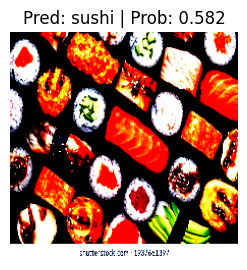

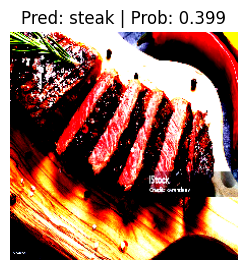

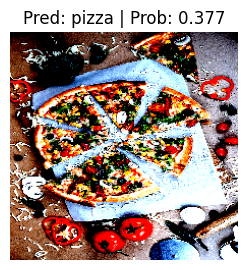

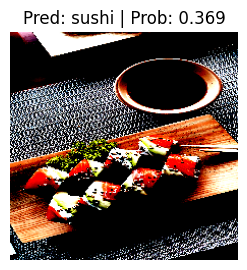

In [23]:
# TODO: Get an image of pizza/steak/sushi
import PIL.Image

steak_image_url = "https://media.istockphoto.com/id/535786572/photo/grilled-striploin-steak.jpg?s=1024x1024&w=is&k=20&c=vCxAYDoDNDQRdmylqzt1c9xZmc6Rq3OvZ4t6u-xQU-c="
pizza_image_url = "https://plus.unsplash.com/premium_photo-1675451537771-0dd5b06b3985?q=80&w=1587&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"
sushi_image_url = "https://images.unsplash.com/photo-1579584425555-c3ce17fd4351?q=80&w=1827&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D"

urls = ["https://www.shutterstock.com/image-photo/assorted-sushi-nigiri-maki-big-260nw-1937661397.jpg", steak_image_url, pizza_image_url, sushi_image_url]

import requests
def get_images(urls):
  custom_image_paths = []
  for i, url in enumerate(urls):
    custom_image_path = data_path / f"test-image-{i}.jpg"


    if not custom_image_path.is_file():
      with open(custom_image_path, "wb") as f:
        request = requests.get(url)
        print(f"Downloading {custom_image_path}")
        custom_image_paths.append(custom_image_path)
        f.write(request.content)
    else:
      print(f"{custom_image_path} already exists")
      custom_image_paths.append(custom_image_path)

  return custom_image_paths

custom_image_paths = get_images(urls)

custom_image_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes) # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

for i, image_path in enumerate(custom_image_paths):
  plt.figure(figsize=(10, 7))
  plt.subplot(2, 3, i+1)
  pred_and_plot_image(
      model=model_0,
      image_path=image_path,
      transform=custom_image_transform,
      class_names=class_names,
      device=device
  )

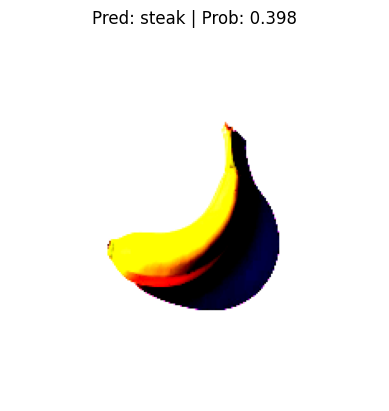

In [24]:
# TODO: Get an image of not pizza/steak/sushi
not_class_image_url = "https://images.unsplash.com/photo-1481349518771-20055b2a7b24?q=80&w=1000&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8NHx8cmFuZG9tfGVufDB8fDB8fHww"
custom_image_path = data_path / "football-image.jpg"
with open(custom_image_path, "wb") as f:
  request = requests.get(not_class_image_url)
  f.write(request.content)

pred_and_plot_image(
    model=model_0,
    image_path=custom_image_path,
    transform=custom_image_transform,
    class_names=class_names,
    device=device
)

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [25]:
# TODO: Recreate a new model
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_1 = torchvision.models.efficientnet_b1(weights=weights).to(device)

for param in model_1.features.parameters():
  param.requires_grad = False

torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(
        in_features=1280,
        out_features=output_shape,
        bias=True
    )
).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:02<00:00, 11.4MB/s]


In [26]:
summary(model_1,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [27]:
# TODO: Train the model for 10 epochs
model_1_results = engine.train(
    model=model_1,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.4062 | test_loss: 1.0796 | test_acc: 0.4441
Epoch: 2 | train_loss: 1.1018 | train_acc: 0.3008 | test_loss: 1.0904 | test_acc: 0.3693
Epoch: 3 | train_loss: 1.1018 | train_acc: 0.3359 | test_loss: 1.0889 | test_acc: 0.2585
Epoch: 4 | train_loss: 1.1096 | train_acc: 0.3477 | test_loss: 1.0989 | test_acc: 0.3097
Epoch: 5 | train_loss: 1.0965 | train_acc: 0.4297 | test_loss: 1.0952 | test_acc: 0.3295
Epoch: 6 | train_loss: 1.1155 | train_acc: 0.2812 | test_loss: 1.0948 | test_acc: 0.3191
Epoch: 7 | train_loss: 1.1209 | train_acc: 0.3008 | test_loss: 1.0968 | test_acc: 0.3295
Epoch: 8 | train_loss: 1.1390 | train_acc: 0.3125 | test_loss: 1.1015 | test_acc: 0.3097
Epoch: 9 | train_loss: 1.1002 | train_acc: 0.2930 | test_loss: 1.1021 | test_acc: 0.3097
Epoch: 10 | train_loss: 1.1081 | train_acc: 0.4414 | test_loss: 1.1036 | test_acc: 0.2992


## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [28]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [29]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [30]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7a8f05270c10>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [35]:
# TODO
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT
model_2 = torchvision.models.efficientnet_b1(weights=weights).to(device)

### Train a model with 20% of the data

In [36]:
# TODO

model_2_results = engine.train(
    model=model_1,
    train_dataloader=train_dataloader_20_percent,
    test_dataloader=test_dataloader_20_percent,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1129 | train_acc: 0.3187 | test_loss: 1.1197 | test_acc: 0.2483
Epoch: 2 | train_loss: 1.1103 | train_acc: 0.3146 | test_loss: 1.1197 | test_acc: 0.2858
Epoch: 3 | train_loss: 1.1148 | train_acc: 0.3187 | test_loss: 1.1191 | test_acc: 0.2705
Epoch: 4 | train_loss: 1.1112 | train_acc: 0.3396 | test_loss: 1.1173 | test_acc: 0.2858
Epoch: 5 | train_loss: 1.1034 | train_acc: 0.4083 | test_loss: 1.1163 | test_acc: 0.2733
Epoch: 6 | train_loss: 1.1055 | train_acc: 0.3958 | test_loss: 1.1171 | test_acc: 0.2858
Epoch: 7 | train_loss: 1.1146 | train_acc: 0.3271 | test_loss: 1.1208 | test_acc: 0.2858
Epoch: 8 | train_loss: 1.1133 | train_acc: 0.3396 | test_loss: 1.1216 | test_acc: 0.2795
Epoch: 9 | train_loss: 1.1044 | train_acc: 0.3708 | test_loss: 1.1183 | test_acc: 0.2824
Epoch: 10 | train_loss: 1.1080 | train_acc: 0.3438 | test_loss: 1.1206 | test_acc: 0.2761


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [68]:
# TODO
from torchvision.models import resnet50, ResNet50_Weights

weights = ResNet50_Weights.DEFAULT
model_3 = resnet50(weights=weights)

In [49]:
default_transform = weights.transforms()
default_transform

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [50]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                               test_dir=test_dir_20_percent,
                                                                               transform=default_transform, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names


(<torch.utils.data.dataloader.DataLoader at 0x7a8f051e6c20>,
 ['pizza', 'steak', 'sushi'])

In [51]:
summary(model=model_3,
        input_size=(32, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [69]:
for name, param in model_3.named_parameters():
  param.requires_grad = False

In [70]:
output_shape = len(class_names)

model_3.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.01, inplace=True),
    torch.nn.Linear(in_features=model_3.fc.in_features,
                    out_features=output_shape,
                    bias=True)
)

In [57]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [58]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

NameError: name 'model' is not defined

In [59]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_3,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1112 | train_acc: 0.2562 | test_loss: 1.1155 | test_acc: 0.3239
Epoch: 2 | train_loss: 1.1132 | train_acc: 0.2812 | test_loss: 1.1112 | test_acc: 0.2619
Epoch: 3 | train_loss: 1.1053 | train_acc: 0.3042 | test_loss: 1.1102 | test_acc: 0.3273
Epoch: 4 | train_loss: 1.1151 | train_acc: 0.3250 | test_loss: 1.1101 | test_acc: 0.3335
Epoch: 5 | train_loss: 1.1107 | train_acc: 0.2917 | test_loss: 1.1116 | test_acc: 0.3119
Epoch: 6 | train_loss: 1.1059 | train_acc: 0.3354 | test_loss: 1.1123 | test_acc: 0.3028
Epoch: 7 | train_loss: 1.1126 | train_acc: 0.2875 | test_loss: 1.1120 | test_acc: 0.3148
Epoch: 8 | train_loss: 1.1093 | train_acc: 0.3250 | test_loss: 1.1094 | test_acc: 0.3176
Epoch: 9 | train_loss: 1.1074 | train_acc: 0.3604 | test_loss: 1.1062 | test_acc: 0.3335
Epoch: 10 | train_loss: 1.1055 | train_acc: 0.3458 | test_loss: 1.1071 | test_acc: 0.3460
Epoch: 11 | train_loss: 1.1158 | train_acc: 0.2896 | test_loss: 1.1092 | test_acc: 0.3364
Epoch: 12 | train_l

In [60]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

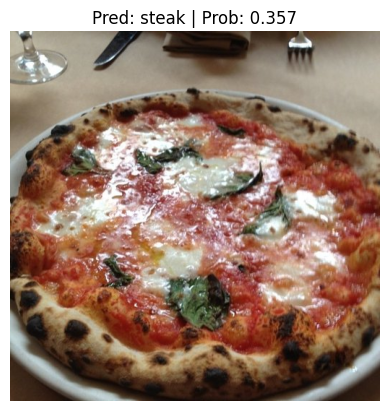

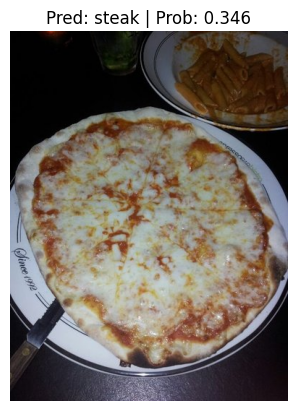

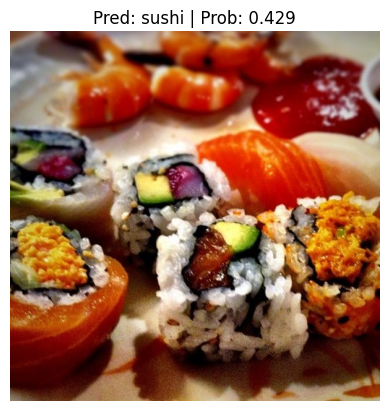

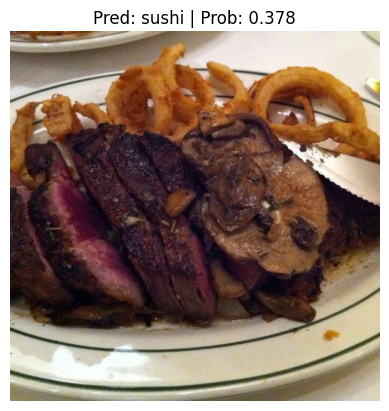

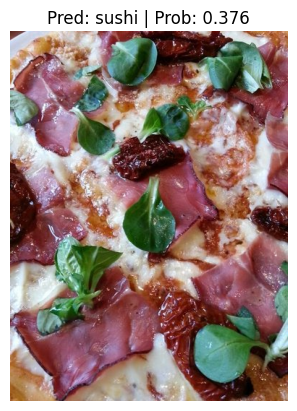

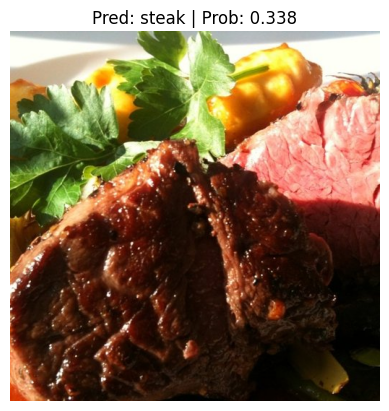

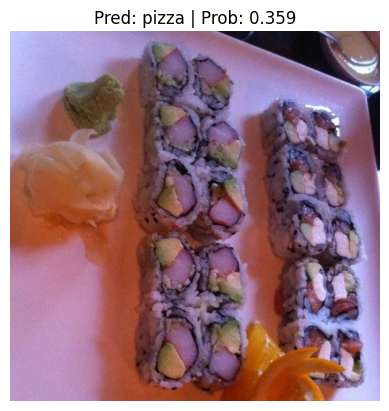

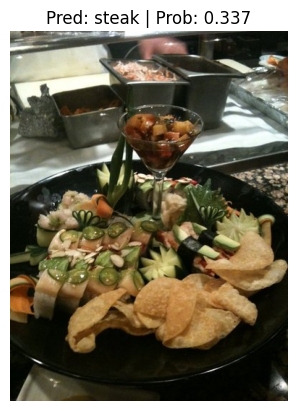

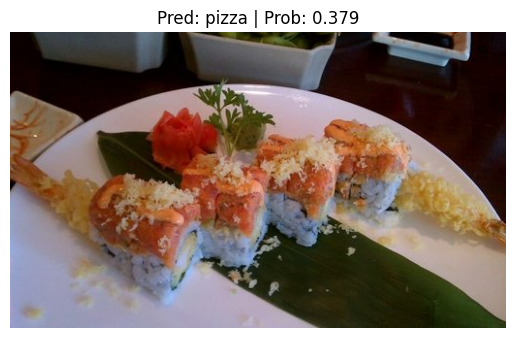

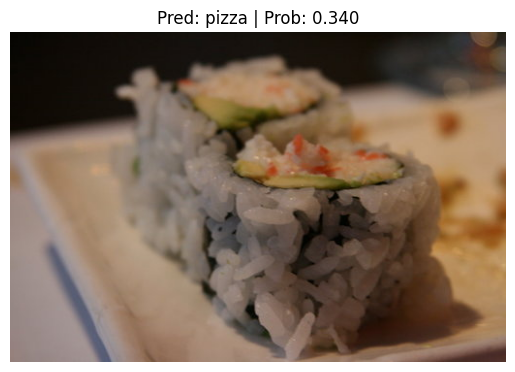

In [63]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 10
test_image_path_list = list(Path(test_dir_20_percent).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model_3,
                        image_path=image_path,
                        class_names=class_names,
                        transform=default_transform, # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))